<a id="section-one"></a>
## Importing needed packages

In [1]:
!pip install matplotlib-scalebar
!pip install fiona
!pip install folium 

In [2]:
import os
import fiona
import folium
import requests
import matplotlib
#import osmnx as ox
import pandas as pd
import geopandas as gpd
import plotly.express as px
from pyproj import Transformer
from folium.plugins import Draw
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from folium.plugins import BeautifyIcon
from sklearn.cluster import MiniBatchKMeans
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.font_manager import FontProperties
from shapely.geometry import Point, LineString, Polygon

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


<a id="section-two"></a>
## Reading the restaurant data

In [3]:
nonna_merged_data = pd.read_csv('London Population /Cleaned_restaurants.csv') #path changes depending on where data is stored


In [4]:
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
# Select the 'Rating Value' column
rating_col = nonna_merged_data['Rating Value']

# Create a mask for rows with missing values
missing_mask = rating_col.eq('AwaitingPublication') | rating_col.eq('AwaitingInspection') | rating_col.eq('Exempt')

# Create a copy of the 'Rating Value' column for imputation
rating_imputed = rating_col.copy()

# Map the string values to NaN
rating_imputed[missing_mask] = np.nan

# Convert the 'Rating Value' column to float type
rating_imputed = rating_imputed.astype(float)

# Creating a regression imputer
imputer = IterativeImputer(estimator=LinearRegression(), random_state=0)

# Fit and transform the 'Rating Value' column with missing values
rating_imputed = imputer.fit_transform(rating_imputed.values.reshape(-1, 1))

# Flatten the imputed values
rating_imputed = rating_imputed.flatten()

# Assign the imputed values back to the original DataFrame
nonna_merged_data.loc[missing_mask, 'Rating Value'] = rating_imputed[:missing_mask.sum()]

# Save the modified DataFrame to a CSV file
#nonna_merged_data.to_csv('new_rating_imputed_data.csv', index=False)



# Select the 'Rating Value' column
hygiene_col = nonna_merged_data['Hygiene']

# Create a mask for rows with missing values
missing_hygiene =  hygiene_col.isnull()

# Create a copy of the 'Rating Value' column for imputation
hygiene_imputed = hygiene_col.copy()

# Map the string values to NaN
hygiene_imputed[missing_hygiene] = np.nan

# Convert the 'Rating Value' column to float type
hygiene_imputed = hygiene_imputed.astype(float)

# Creating a regression imputer
imputer = IterativeImputer(estimator=LinearRegression(), random_state=0)

# Fit and transform the 'Rating Value' column with missing values
hygiene_imputed = imputer.fit_transform(hygiene_imputed.values.reshape(-1, 1))

# Flatten the imputed values
hygiene_imputed = hygiene_imputed.flatten()

# Assign the imputed values back to the original DataFrame
nonna_merged_data.loc[missing_hygiene, 'Hygiene'] = hygiene_imputed[:missing_hygiene.sum()]

# Save the modified DataFrame to a CSV file
#nonna_merged_data.to_csv('new_hygiene_imputed_data.csv', index=False)



In [5]:
nonna_merged_data.columns


Index(['Unnamed: 0', 'Address ', 'Business Name ', 'Business Type',
       'BusinessTypeID', 'FHRSID', 'Latitude', 'Longitude',
       'Local Authority BusinessID', 'Local Authority Code',
       'Local Authority Email Address', 'Local Authority Name',
       'Local Authority WebSite', 'New Rating Pending', 'Post Code',
       'Rating Key', 'Rating Value', 'Scheme Type', 'Confidence In Management',
       'Hygiene', ' Structural', '/Header/ItemCount/#agg'],
      dtype='object')

In [6]:
columns_drop = [' Structural','Scheme Type','Confidence In Management','Local Authority WebSite','New Rating Pending']
nonna_merged_data.drop(columns = columns_drop, inplace = True)

In [7]:
nonna_merged_data.dropna(subset = ['Latitude','Longitude'])

,Unnamed: 0,Address,Business Name,Business Type,BusinessTypeID,FHRSID,Latitude,Longitude,Local Authority BusinessID,Local Authority Code,Local Authority Email Address,Local Authority Name,Post Code,Rating Key,Rating Value,Hygiene,/Header/ItemCount/#agg
1,1,Rio Cinema Dalston 103-107 Kingsland High Stre...,"""Rio Cinema""",Restaurant/Cafe/Canteen,1.0,468824.0,51.549539,-0.075568,1317,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E8 2PB,fhrs_3_en-GB,3,10.000000,NaN
2,2,Railway Arch 214 Ponsford Street Hackney London,% Arabica,Manufacturers/packers,7839.0,1220366.0,51.547348,-0.048531,191074,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E9 6JU,fhrs_2_en-GB,2,5.000000,NaN
3,3,Basement To Ground Floor 33 Broadway Market Ha...,%Arabica,Other catering premises,7841.0,1225476.0,51.536510,-0.062051,130435,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E8 4PH,fhrs_5_en-GB,5,5.000000,NaN
4,4,45-47 lower Clapton road Hackney London,&organic ltd,Restaurant/Cafe/Canteen,1.0,1527059.0,51.550962,-0.052203,HAC1459,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E50NS,fhrs_awaitinginspection_en-GB,5.0,5.000000,NaN
6,6,485 kingsland road Hackney London,@las coffee house,Restaurant/Cafe/Canteen,1.0,1578908.0,51.544256,-0.076300,HAC1551,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E84AU,fhrs_4_en-GB,4,5.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78778,78778,2 Castle Street Kingston Upon Thames,Yoriya,Takeaway/sandwich shop,7844.0,1385803.0,51.411049,-0.301725,21/00085/COM,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,KT1 1SS,fhrs_1_en-GB,1,15.000000,NaN
78779,78779,96 Burlington Road New Malden,You Me Korean Restaurant,Restaurant/Cafe/Canteen,1.0,1386083.0,51.398814,-0.249460,21/10939/RBK,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,KT3 4NT,fhrs_3_en-GB,3,10.000000,NaN
78781,78781,43 Market Place Kingston Upon Thames,Zizzi And Coco Di Mama,Restaurant/Cafe/Canteen,1.0,1386687.0,51.408839,-0.306178,21/97574/RBK,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,KT1 1ET,fhrs_5_en-GB,5,5.000000,NaN
78782,78782,Kings Oak Primary School Dickerage Lane New Ma...,Zone All Sports And Care At Kings Oak Primary ...,School/college/university,7845.0,1594642.0,51.404842,-0.274529,23/00055/COM,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,KT3 3RZ,fhrs_5_en-GB,5,5.000000,NaN


In [8]:
gdf = gpd.GeoDataFrame(nonna_merged_data, geometry= gpd.points_from_xy(nonna_merged_data.Longitude, nonna_merged_data.Latitude))
gdf.head()

,Unnamed: 0,Address,Business Name,Business Type,BusinessTypeID,FHRSID,Latitude,Longitude,Local Authority BusinessID,Local Authority Code,Local Authority Email Address,Local Authority Name,Post Code,Rating Key,Rating Value,Hygiene,/Header/ItemCount/#agg,geometry
0,0,"432-434 Kingsland Road, London E8 4AA Hackney...","""MU""",Restaurant/Cafe/Canteen,1.0,1584416.0,NaN,NaN,HAC1603,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E8 4AA,fhrs_5_en-GB,5,5.0,NaN,POINT EMPTY
1,1,Rio Cinema Dalston 103-107 Kingsland High Stre...,"""Rio Cinema""",Restaurant/Cafe/Canteen,1.0,468824.0,51.549539,-0.075568,1317,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E8 2PB,fhrs_3_en-GB,3,10.0,NaN,POINT (-0.07557 51.54954)
2,2,Railway Arch 214 Ponsford Street Hackney London,% Arabica,Manufacturers/packers,7839.0,1220366.0,51.547348,-0.048531,191074,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E9 6JU,fhrs_2_en-GB,2,5.0,NaN,POINT (-0.04853 51.54735)
3,3,Basement To Ground Floor 33 Broadway Market Ha...,%Arabica,Other catering premises,7841.0,1225476.0,51.536510,-0.062051,130435,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E8 4PH,fhrs_5_en-GB,5,5.0,NaN,POINT (-0.06205 51.53651)
4,4,45-47 lower Clapton road Hackney London,&organic ltd,Restaurant/Cafe/Canteen,1.0,1527059.0,51.550962,-0.052203,HAC1459,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E50NS,fhrs_awaitinginspection_en-GB,5.0,5.0,NaN,POINT (-0.05220 51.55096)


In [9]:
gdf.crs = "EPSG:4326" #Adding crs information to geodataframe
#gdf.plot(marker = '*', color = 'green') #Plotting the geodataframe
#plt.rcParams['figure.figsize'] = [10, 10] 

<a id="section-three"></a>
## Visualizing restaurant data

In [10]:
# #Loading United Kingdom Data from gpd datasets
# # load a sample geodataframe
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))  
# uk = world[world['name'] == 'United Kingdom']

# ax = uk.plot(color ='#e3bccf', edgecolor = 'blue')
# plt.rcParams['figure.figsize'] = [10, 10] 

# for x, y, label in zip(uk.geometry.representative_point().x, uk.geometry.representative_point().y, africa_gdf.name):
#     ax.annotate(label, xy=(x, y))
    
# gdf.plot(ax=ax, color = 'green')

#### From the plot above it can be seen that not all the points are in London, and will be removed...
#### To do this, we need another dataset that has the London spatial data information, ie London shapefile...

In [11]:
london = gpd.read_file("London Population /London_Borough_Excluding_MHW.shp")
london.crs #crs here is projected wherea~s points geodataframe ('gdf') is geographic crs as seen in the next cell

<Projected CRS: PROJCS["OSGB36 / British National Grid",GEOGCS["OS ...>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [12]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [13]:
london['geometry'].to_crs(epsg=4326)#, allow_override=True)
london_new = london.to_crs(epsg=4326)#, allow_override=True)
london_new.head()

,geometry
0,"POLYGON ((-0.33068 51.32901, -0.33059 51.32909..."
1,"POLYGON ((-0.06402 51.31864, -0.06408 51.31861..."
2,"POLYGON ((0.01213 51.29960, 0.01196 51.29980, ..."
3,"POLYGON ((-0.24456 51.48870, -0.24468 51.48868..."
4,"POLYGON ((-0.41183 51.53408, -0.41188 51.53412..."


Breakdown of spatial datasets we have so far...
1. gdf
2. london
3. london_new


In [14]:
london_new.crs #geographic coordinate system

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
# ax = london.plot()
# gdf.plot(ax=ax)

#ax = gdf.plot(alpha=0.1, color='green')
#london_new.plot(ax=ax, color = '#C6A619')

#### Plot is not very intuitive, london boundary is shown by a small yellow dot!

In [16]:
#london_new.plot(color='#C6A619')

From the london plot above, it is seen that the highest latitude value is about 51.7 and the lowest value about 51.2
the lowest longitude value is about -0.2 and the highest value about 0.4

In [17]:
to_del = []
long_del_east = gdf[gdf['Longitude'] > 0.4].index.to_list()
long_del_west = gdf[gdf['Longitude'] <-0.5].index.to_list()
lat_del_upper = gdf[gdf['Latitude'] >51.7].index.to_list()
lat_del_lower = gdf[gdf['Latitude'] <51.2].index.to_list()

to_del.extend(long_del_east)
to_del.extend(long_del_west)
to_del.extend(lat_del_upper)
to_del.extend(lat_del_lower)
print(len(to_del))
to_del = set(to_del)
print(len(to_del))

53
36


In [18]:
print(f'Before deletion of rows: {len(gdf)}')
gdf = gdf.drop(index=to_del)
print(f'After deletion of rows: {len(gdf)}')

Before deletion of rows: 78785
After deletion of rows: 78749


In [19]:
#gdf.plot() #looks much better, and within the london area range

In [20]:
# ax = london_new.plot(edgecolor='blue',color='#F1C40F')
# gdf.plot(ax=ax, marker='*')
# plt.rcParams['figure.figsize']= [8, 8]  #Some points are shown outside the boundary of london but can be ignored for now

In [21]:
gdf.geometry

0                      POINT EMPTY
1        POINT (-0.07557 51.54954)
2        POINT (-0.04853 51.54735)
3        POINT (-0.06205 51.53651)
4        POINT (-0.05220 51.55096)
                   ...            
78780                  POINT EMPTY
78781    POINT (-0.30618 51.40884)
78782    POINT (-0.27453 51.40484)
78783                  POINT EMPTY
78784    POINT (-0.25778 51.38109)
Name: geometry, Length: 78749, dtype: geometry

In [22]:
gdf.dropna(subset = ['Business Name '])

,Unnamed: 0,Address,Business Name,Business Type,BusinessTypeID,FHRSID,Latitude,Longitude,Local Authority BusinessID,Local Authority Code,Local Authority Email Address,Local Authority Name,Post Code,Rating Key,Rating Value,Hygiene,/Header/ItemCount/#agg,geometry
0,0,"432-434 Kingsland Road, London E8 4AA Hackney...","""MU""",Restaurant/Cafe/Canteen,1.0,1584416.0,NaN,NaN,HAC1603,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E8 4AA,fhrs_5_en-GB,5,5.000000,NaN,POINT EMPTY
1,1,Rio Cinema Dalston 103-107 Kingsland High Stre...,"""Rio Cinema""",Restaurant/Cafe/Canteen,1.0,468824.0,51.549539,-0.075568,1317,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E8 2PB,fhrs_3_en-GB,3,10.000000,NaN,POINT (-0.07557 51.54954)
2,2,Railway Arch 214 Ponsford Street Hackney London,% Arabica,Manufacturers/packers,7839.0,1220366.0,51.547348,-0.048531,191074,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E9 6JU,fhrs_2_en-GB,2,5.000000,NaN,POINT (-0.04853 51.54735)
3,3,Basement To Ground Floor 33 Broadway Market Ha...,%Arabica,Other catering premises,7841.0,1225476.0,51.536510,-0.062051,130435,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E8 4PH,fhrs_5_en-GB,5,5.000000,NaN,POINT (-0.06205 51.53651)
4,4,45-47 lower Clapton road Hackney London,&organic ltd,Restaurant/Cafe/Canteen,1.0,1527059.0,51.550962,-0.052203,HAC1459,512.0,technicalbusinesssupport@hackney.gov.uk,Hackney,E50NS,fhrs_awaitinginspection_en-GB,5.0,5.000000,NaN,POINT (-0.05220 51.55096)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78780,78780,,Zays Bakes,Other catering premises,7841.0,1498540.0,NaN,NaN,22/00135/COM,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,NaN,fhrs_5_en-GB,5,0.000000,NaN,POINT EMPTY
78781,78781,43 Market Place Kingston Upon Thames,Zizzi And Coco Di Mama,Restaurant/Cafe/Canteen,1.0,1386687.0,51.408839,-0.306178,21/97574/RBK,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,KT1 1ET,fhrs_5_en-GB,5,5.000000,NaN,POINT (-0.30618 51.40884)
78782,78782,Kings Oak Primary School Dickerage Lane New Ma...,Zone All Sports And Care At Kings Oak Primary ...,School/college/university,7845.0,1594642.0,51.404842,-0.274529,23/00055/COM,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,KT3 3RZ,fhrs_5_en-GB,5,5.000000,NaN,POINT (-0.27453 51.40484)
78783,78783,Malden Manor Primary And Nursery School Sheeph...,Zone All Sports And Care At Malden Manor Primary,School/college/university,7845.0,1594643.0,NaN,NaN,23/00056/COM,521.0,food.safety@kingston.gov.uk,Kingston-Upon-Thames,KT3 5PF,fhrs_awaitinginspection_en-GB,5.0,0.000000,NaN,POINT EMPTY


<a id="section-five"></a>
## Geopandas and folium plots

<a id="subsection-five-c"></a>
### Functions for folium plots

## Tube Data

In [23]:
coordinates_df = pd.read_csv("London Population /Candidate_location.csv")

In [24]:
gdf_influential_candidate = gpd.GeoDataFrame(coordinates_df, geometry= gpd.points_from_xy(coordinates_df.Longitude, coordinates_df.Latitude))
gdf_influential_candidate

,Unnamed: 0,Latitude,Longitude,geometry
0,0,51.517056,-0.134272,POINT (-0.13427 51.51706)
1,1,51.531264,-0.135680,POINT (-0.13568 51.53126)
2,2,51.492764,-0.080156,POINT (-0.08016 51.49276)
3,3,51.524576,-0.112032,POINT (-0.11203 51.52458)
4,4,51.524504,-0.112087,POINT (-0.11209 51.52450)
5,5,51.558080,0.072384,POINT (0.07238 51.55808)
6,6,51.586048,-0.328704,POINT (-0.32870 51.58605)
7,7,51.375744,-0.091776,POINT (-0.09178 51.37574)
8,8,51.404288,-0.292352,POINT (-0.29235 51.40429)
9,9,51.554048,-0.173824,POINT (-0.17382 51.55405)


---------

<a id="subsection-seven-a"></a>
### Reading london tube data (stations and lines)

#### Tube data downloaded from downloaded from https://www.doogal.co.uk/london_stations

In [25]:
tube_df = pd.read_csv('London Population /London tube lines.csv')
tube_df.head()

,Tube Line,From Station,To Station
0,Bakerloo,Baker Street,Regents Park
1,Bakerloo,Charing Cross,Embankment
2,Bakerloo,Edgware Road (Bakerloo),Marylebone
3,Bakerloo,Embankment,Waterloo
4,Bakerloo,Harlesden,Willesden Junction


In [26]:
# gpd.read_file('London_Train_Lines.kml')

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
tube_linesgdf = gpd.read_file('London Population /London_Train_Lines (1).kml', driver='KML')
tube_linesgdf.head()

,Name,Description,geometry
0,Bakerloo - Baker Street to Regents Park,,"LINESTRING Z (-0.15690 51.52313 1.00000, -0.14..."
1,Bakerloo - Charing Cross to Embankment,,"LINESTRING Z (-0.12480 51.50836 1.00000, -0.12..."
2,Bakerloo - Edgware Road (Bakerloo) to Marylebone,,"LINESTRING Z (-0.17054 51.52065 1.00000, -0.16..."
3,Bakerloo - Embankment to Waterloo,,"LINESTRING Z (-0.12237 51.50731 1.00000, -0.11..."
4,Bakerloo - Harlesden to Willesden Junction,,"LINESTRING Z (-0.25750 51.53626 1.00000, -0.24..."


In [27]:
# gpd.read_file('London_Train_Lines.kml')

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
tube_stnsgdf = gpd.read_file('London Population /london_tube_stations.kml', driver='KML')
tube_stnsgdf.head()

,Name,Description,geometry
0,Abbey Road,<div>Zone 3</div> <div>E15 3NB</div> <div>Lati...,POINT Z (0.00372 51.53195 0.00000)
1,Abbey Wood,<div>Zone 4</div> <div>SE2 9RH</div> <div>Lati...,POINT Z (0.12027 51.49078 0.00000)
2,Acton Central,<div>Zone 2</div> <div>W3 6BH</div> <div>Latit...,POINT Z (-0.26343 51.50876 0.00000)
3,Acton Main Line,<div>Zone 3</div> <div>W3 9EH</div> <div>Latit...,POINT Z (-0.26769 51.51689 0.00000)
4,Acton Town,<div>Zone 3</div> <div>W3 8HN</div> <div>Latit...,POINT Z (-0.28030 51.50307 0.00000)


In [28]:
# gpd.read_file('London_Train_Lines.kml')

gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
tube_stnsgdf_distance = gpd.read_file('London Population /london_tube_stations.kml', driver='KML')
tube_stnsgdf_distance.head()

,Name,Description,geometry
0,Abbey Road,<div>Zone 3</div> <div>E15 3NB</div> <div>Lati...,POINT Z (0.00372 51.53195 0.00000)
1,Abbey Wood,<div>Zone 4</div> <div>SE2 9RH</div> <div>Lati...,POINT Z (0.12027 51.49078 0.00000)
2,Acton Central,<div>Zone 2</div> <div>W3 6BH</div> <div>Latit...,POINT Z (-0.26343 51.50876 0.00000)
3,Acton Main Line,<div>Zone 3</div> <div>W3 9EH</div> <div>Latit...,POINT Z (-0.26769 51.51689 0.00000)
4,Acton Town,<div>Zone 3</div> <div>W3 8HN</div> <div>Latit...,POINT Z (-0.28030 51.50307 0.00000)


In [29]:
import pandas as pd
from shapely.geometry import Point

# Assuming you have the data in a DataFrame named 'tube_stnsgdf_distance'

# Define a function to extract latitude and longitude from the Point object
def get_lat_lon(point):
    return point.x, point.y

# Convert the "geometry" column to Point objects
tube_stnsgdf_distance['geometry'] = tube_stnsgdf_distance['geometry'].apply(Point)

# Extract latitude and longitude from the Point objects and create new columns
tube_stnsgdf_distance['Latitude'], tube_stnsgdf_distance['Longitude'] = zip(*tube_stnsgdf_distance['geometry'].map(get_lat_lon))

# Display the DataFrame with the new "Latitude" and "Longitude" columns
print(tube_stnsgdf_distance[['Name', 'Description', 'Latitude', 'Longitude']])


                  Name                                        Description  \
0           Abbey Road  <div>Zone 3</div> <div>E15 3NB</div> <div>Lati...   
1           Abbey Wood  <div>Zone 4</div> <div>SE2 9RH</div> <div>Lati...   
2        Acton Central  <div>Zone 2</div> <div>W3 6BH</div> <div>Latit...   
3      Acton Main Line  <div>Zone 3</div> <div>W3 9EH</div> <div>Latit...   
4           Acton Town  <div>Zone 3</div> <div>W3 8HN</div> <div>Latit...   
..                 ...                                                ...   
649      Woodside Park  <div>Zone 4</div> <div>N12 8SE</div> <div>Lati...   
650           Woolwich  <div>Zone 4</div> <div>SE18 6EU</div> <div>Lat...   
651   Woolwich Arsenal  <div>Zone 4</div> <div>SE18 6HX</div> <div>Lat...   
652  Woolwich Dockyard  <div>Zone 3</div> <div>SE18 5JY</div> <div>Lat...   
653     Worcester Park  <div>Zone 4</div> <div>KT4 7ND</div> <div>Lati...   

     Latitude  Longitude  
0    0.003723  51.531952  
1    0.120272  51.490

In [30]:
[i for i in tube_linesgdf.loc[[0]].geometry[0].coords]

[(-0.15690419298618452, 51.52312936605881, 1.0),
 (-0.1453444097205957, 51.523810437772845, 1.0)]

Text(0.5, 1.0, 'London tube lines')

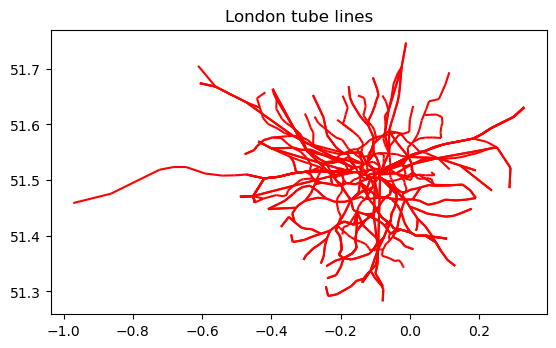

In [31]:
tube_linesgdf.plot(color='red')
plt.title('London tube lines')

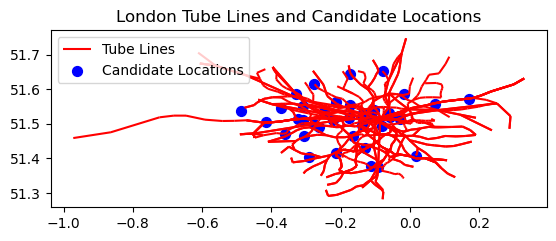

In [32]:
#showing what the tube lines look like in the real world
tube_linesgdf.plot(color='red',label='Tube Lines')
## Plotting the candidate locations
gdf_influential_candidate.plot(ax=plt.gca(), color='blue', marker='o', markersize=50, label='Candidate Locations')

# Set the title and legend
plt.title('London Tube Lines and Candidate Locations')
plt.legend()

# Show the plot
plt.show()






In [33]:
# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# Plot tube lines on the map
folium.GeoJson(tube_linesgdf, name='Tube Lines', style_function=lambda x: {'color': 'red'}).add_to(m)

# Plot candidate locations on the map
for idx, row in gdf_influential_candidate.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=f'Candidate Location {idx+1}', icon=folium.Icon(color='blue')).add_to(m)

# Add layer control to toggle between tube lines and candidate locations
folium.LayerControl().add_to(m)

# Display the map
m

#### Obtaining from and to locations from tube lines to be added to a folium feature group

[list(tube_linesgdf.apply(lambda row: row.loc[[i for i in tube_linesgdf['indexx']]]).geometry[index_no].coords) for index_no in tube_linesgdf.index]


In [34]:
tube_stnsgdf.explore(color='red')  #showing what the points look like in the real world

In [35]:
tube_stnsgdf.columns

Index(['Name', 'Description', 'geometry'], dtype='object')

In [36]:
# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# Plot tube lines on the map
folium.GeoJson(tube_stnsgdf, name='Tube stations', style_function=lambda x: {'color': 'red'}).add_to(m)

# Plot candidate locations on the map
for idx, row in gdf_influential_candidate.iterrows():
    folium.Marker([row['Latitude'], row['Longitude']], popup=f'Candidate Location {idx+1}', icon=folium.Icon(color='red')).add_to(m)

# Add layer control to toggle between tube lines and candidate locations
folium.LayerControl().add_to(m)

# Display the map
m

In [37]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [38]:
gdf_influential_candidate

,Unnamed: 0,Latitude,Longitude,geometry
0,0,51.517056,-0.134272,POINT (-0.13427 51.51706)
1,1,51.531264,-0.135680,POINT (-0.13568 51.53126)
2,2,51.492764,-0.080156,POINT (-0.08016 51.49276)
3,3,51.524576,-0.112032,POINT (-0.11203 51.52458)
4,4,51.524504,-0.112087,POINT (-0.11209 51.52450)
5,5,51.558080,0.072384,POINT (0.07238 51.55808)
6,6,51.586048,-0.328704,POINT (-0.32870 51.58605)
7,7,51.375744,-0.091776,POINT (-0.09178 51.37574)
8,8,51.404288,-0.292352,POINT (-0.29235 51.40429)
9,9,51.554048,-0.173824,POINT (-0.17382 51.55405)


In [39]:
from geopy.distance import geodesic
# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# Plot tube stations on the map
# for idx, row in tube_stnsgdf.iterrows():
#     tube_station_coords = (row['geometry'].y, row['geometry'].x)
#     folium.Marker(tube_station_coords, popup=f'Tube Station: {row["Name"]}', icon=folium.Icon(color='red')).add_to(m)
candidate_locations = []
nearest_tube_stations = []
distances = []
tube_coordinates_y = []
tube_coordinates_x = []
candidate_longitude = []
candidate_latitude =[]
# Plot candidate locations on the map and calculate distance to the nearest tube station
for idx, row in gdf_influential_candidate.iterrows():
    candidate_coords = (row['Latitude'], row['Longitude'])
    folium.Marker(candidate_coords, popup=f'Candidate Location {idx+1}', icon=folium.Icon(color='blue')).add_to(m)

    # Calculate distance to the nearest tube station
    nearest_tube_station = tube_stnsgdf_distance.iloc[
        tube_stnsgdf.apply(lambda tube: geodesic(candidate_coords, (tube['geometry'].y, tube['geometry'].x)).km, axis=1).idxmin()
    ]
    distance_km = geodesic(candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)).km
     # Add data to the lists
    candidate_locations.append(f'Candidate Location {idx+1}')
    candidate_latitude.append(candidate_coords[0])
    candidate_longitude.append(candidate_coords[1])
    nearest_tube_stations.append(nearest_tube_station['Name'])
    distances.append(distance_km)
    tube_coordinates_y.append(nearest_tube_station['Latitude'])
    tube_coordinates_x.append(nearest_tube_station['Longitude'])







    # Add a line between candidate location and nearest tube station
    folium.PolyLine([candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)], color='green').add_to(m)
    folium.Marker((nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x), popup=f'Nearest Tube Station: {nearest_tube_station["Name"]}\nDistance: {distance_km:.2f} km', icon=folium.Icon(color='green')).add_to(m)

# Add layer control to toggle between tube stations and candidate locations
folium.LayerControl().add_to(m)

# Create the DataFrame for the table
table_data = {
    'Candidate Location': candidate_locations,
    'Candidate_latitude': candidate_latitude,
    'Candidate_longitude': candidate_longitude,
    'Nearest Tube Station': nearest_tube_stations,
    'Distance (km)': distances,
    'Latitude': tube_coordinates_y,
    'Longitude': tube_coordinates_x
}
table_df = pd.DataFrame(table_data)

m

In [40]:
from geopy.distance import geodesic
import folium
import pandas as pd
from math import radians
# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# Assume you have the DataFrame 'tube_stnsgdf' with tube station data

# Plot candidate locations on the map and calculate distance to the nearest tube station
for idx, row in gdf_influential_candidate.iterrows():
    candidate_coords = (row['Latitude'], row['Longitude'])
    icon_html = f'<div style="display:inline-block;padding:5px;background-color:blue;color:white;border-radius:50%;font-weight:bold;">{idx + 1}</div>'
    folium.Marker(candidate_coords, icon=folium.DivIcon(html=icon_html)).add_to(m)

    # Calculate distance to the nearest tube station
    nearest_tube_station = tube_stnsgdf_distance.iloc[
        tube_stnsgdf_distance.apply(lambda tube: geodesic(candidate_coords, (tube['geometry'].y, tube['geometry'].x)).km, axis=1).idxmin()
    ]
    distance_km = geodesic(candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)).km

    # Add a line between candidate location and nearest tube station
    folium.PolyLine([candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)], color='green').add_to(m)
    folium.Marker((nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x), icon=folium.Icon(color='green')).add_to(m)

# Add layer control to toggle between tube stations and candidate locations
folium.LayerControl().add_to(m)

# Create the DataFrame for the table
table_data = {
    'Candidate Location': [],
    'Candidate_latitude': [],
    'Candidate_longitude': [],
    'Nearest Tube Station': [],
    'Distance (km)': [],
    'Latitude': [],
    'Longitude': []
}

# Populate the table_data dictionary
for idx, row in gdf_influential_candidate.iterrows():
    candidate_coords = (row['Latitude'], row['Longitude'])
    nearest_tube_station = tube_stnsgdf_distance.iloc[
        tube_stnsgdf_distance.apply(lambda tube: geodesic(candidate_coords, (tube['geometry'].y, tube['geometry'].x)).km, axis=1).idxmin()
    ]
    distance_km = geodesic(candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)).km

    table_data['Candidate Location'].append(f'Candidate Location {idx+1}')
    table_data['Candidate_latitude'].append(candidate_coords[0])
    table_data['Candidate_longitude'].append(candidate_coords[1])
    table_data['Nearest Tube Station'].append(nearest_tube_station['Name'])
    table_data['Distance (km)'].append(distance_km)
    table_data['Latitude'].append(nearest_tube_station['Latitude'])
    table_data['Longitude'].append(nearest_tube_station['Longitude'])

# Create the DataFrame
table_df = pd.DataFrame(table_data)

# Display the map and the DataFrame
m


### Distance between existing location and tube stations. 

In [41]:
existing_location = pd.read_csv('Distance_candidate_existing.csv')

In [42]:
existing_location.columns

Index(['Unnamed: 0', 'Candidate Latitude', 'Candidate Longitude',
       'Restaurant Name', 'Restaurant Cuisine Type', 'Restaurant Latitude',
       'Restaurant Longitude', 'Distance'],
      dtype='object')

In [43]:
merge_candidate_location_tube = pd.merge(existing_location,table_df, left_on = ['Candidate Latitude','Candidate Longitude'], right_on = ['Candidate_latitude','Candidate_longitude'], how = 'left')

In [44]:
merge_candidate_location_tube

,Unnamed: 0,Candidate Latitude,Candidate Longitude,Restaurant Name,Restaurant Cuisine Type,Restaurant Latitude,Restaurant Longitude,Distance,Candidate Location,Candidate_latitude,Candidate_longitude,Nearest Tube Station,Distance (km),Latitude,Longitude
0,0,51.375744,-0.091776,Porter & Sorter,Nightlife Bars,51.375996,-0.091879,0.028880,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716
1,1,51.375744,-0.091776,AMT Coffee,Coffee Tea Caf,51.374989,-0.092898,0.114547,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716
2,2,51.375744,-0.091776,Costa Coffee,Cafe,51.374989,-0.092898,0.114547,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716
3,3,51.375744,-0.091776,Sodexo Ltd @ Defence And Govt,Pan Restaurant,51.376292,-0.093524,0.135754,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716
4,4,51.375744,-0.091776,Big Mikes Calypso Kitchen,"Caribbean, Healthy, Jamaican",51.374892,-0.093697,0.163585,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,51.651840,-0.077056,Silverways School,Pan Restaurant,51.652896,-0.081317,0.316531,Candidate Location 11,51.651840,-0.077056,Enfield Town,0.158045,-0.079330,51.651970
1196,1196,51.651840,-0.077056,St Andrews Church Hall,Pan Restaurant,51.653003,-0.081410,0.327032,Candidate Location 11,51.651840,-0.077056,Enfield Town,0.158045,-0.079330,51.651970
1197,1197,51.651840,-0.077056,Caffe Nero,Cafe,51.651517,-0.081790,0.328567,Candidate Location 11,51.651840,-0.077056,Enfield Town,0.158045,-0.079330,51.651970
1198,1198,51.651840,-0.077056,The Fresh Bean Trading Company,Coffee Tea,51.654663,-0.075575,0.330142,Candidate Location 11,51.651840,-0.077056,Enfield Town,0.158045,-0.079330,51.651970


In [45]:
from sklearn.metrics.pairwise import haversine_distances
from math import radians
# Function to calculate distance between two points using haversine formula
def calculate_distance(row):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [row['Restaurant Latitude'], row['Restaurant Longitude'], row['Longitude'], row['Latitude']])

    # Haversine formula
    distances = haversine_distances(np.array([[lat1, lon1], [lat2, lon2]]))

    # Radius of the Earth in kilometers
    radius = 6371.0

    # Calculate the distance
    distance = distances[0, 1] * radius
    return distance

# Assuming you have the DataFrame named 'merge_candidate_location_tube' with the given columns
merge_candidate_location_tube['Distance to Tube Station (km)'] = merge_candidate_location_tube.apply(calculate_distance, axis=1)


In [46]:
merge_candidate_location_tube

,Unnamed: 0,Candidate Latitude,Candidate Longitude,Restaurant Name,Restaurant Cuisine Type,Restaurant Latitude,Restaurant Longitude,Distance,Candidate Location,Candidate_latitude,Candidate_longitude,Nearest Tube Station,Distance (km),Latitude,Longitude,Distance to Tube Station (km)
0,0,51.375744,-0.091776,Porter & Sorter,Nightlife Bars,51.375996,-0.091879,0.028880,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716,0.031114
1,1,51.375744,-0.091776,AMT Coffee,Coffee Tea Caf,51.374989,-0.092898,0.114547,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716,0.108183
2,2,51.375744,-0.091776,Costa Coffee,Cafe,51.374989,-0.092898,0.114547,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716,0.108183
3,3,51.375744,-0.091776,Sodexo Ltd @ Defence And Govt,Pan Restaurant,51.376292,-0.093524,0.135754,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716,0.131868
4,4,51.375744,-0.091776,Big Mikes Calypso Kitchen,"Caribbean, Healthy, Jamaican",51.374892,-0.093697,0.163585,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716,0.156862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,51.651840,-0.077056,Silverways School,Pan Restaurant,51.652896,-0.081317,0.316531,Candidate Location 11,51.651840,-0.077056,Enfield Town,0.158045,-0.079330,51.651970,0.171426
1196,1196,51.651840,-0.077056,St Andrews Church Hall,Pan Restaurant,51.653003,-0.081410,0.327032,Candidate Location 11,51.651840,-0.077056,Enfield Town,0.158045,-0.079330,51.651970,0.183807
1197,1197,51.651840,-0.077056,Caffe Nero,Cafe,51.651517,-0.081790,0.328567,Candidate Location 11,51.651840,-0.077056,Enfield Town,0.158045,-0.079330,51.651970,0.177032
1198,1198,51.651840,-0.077056,The Fresh Bean Trading Company,Coffee Tea,51.654663,-0.075575,0.330142,Candidate Location 11,51.651840,-0.077056,Enfield Town,0.158045,-0.079330,51.651970,0.395969


In [47]:
# Assuming you have the DataFrame named 'merge_candidate_location_tube' with the given columns
# Group by "Candidate Location" and calculate the average of "Distance to Tube Station (km)"
average_distance_per_location = merge_candidate_location_tube.groupby('Candidate Location')['Distance to Tube Station (km)'].mean()

# The resulting Series will have the average distance for each "Candidate Location"
print(average_distance_per_location)


Candidate Location
Candidate Location 1     0.259065
Candidate Location 10    0.255174
Candidate Location 11    0.172694
Candidate Location 12    0.271767
Candidate Location 13    0.478270
Candidate Location 14    0.264513
Candidate Location 15    0.496709
Candidate Location 16    0.421160
Candidate Location 17    0.406920
Candidate Location 18    0.570743
Candidate Location 19    0.202533
Candidate Location 2     0.225222
Candidate Location 20    0.341501
Candidate Location 21    0.116202
Candidate Location 22    0.231671
Candidate Location 23    0.724633
Candidate Location 24    0.335104
Candidate Location 25    0.513325
Candidate Location 26    0.204618
Candidate Location 27    0.383367
Candidate Location 28    0.358603
Candidate Location 29    0.444247
Candidate Location 3     1.329872
Candidate Location 30    1.006858
Candidate Location 31    0.534228
Candidate Location 32    0.368343
Candidate Location 33    0.158925
Candidate Location 34    0.802050
Candidate Location 35    0.82

In [48]:
tube_station_distance = pd.merge(table_df,average_distance_per_location, on = 'Candidate Location')

In [49]:
tube_station_distance.to_csv("tube_stattion_distance.csv")

In [50]:
tube_station_distance

,Candidate Location,Candidate_latitude,Candidate_longitude,Nearest Tube Station,Distance (km),Latitude,Longitude,Distance to Tube Station (km)
0,Candidate Location 1,51.517056,-0.134272,Tottenham Court Road,0.238778,-0.131110,51.516211,0.259065
1,Candidate Location 2,51.531264,-0.135680,Euston,0.333238,-0.133296,51.528664,0.225222
2,Candidate Location 3,51.492764,-0.080156,Bermondsey,1.241891,-0.064330,51.497961,1.329872
3,Candidate Location 4,51.524576,-0.112032,Chancery Lane,0.676690,-0.111962,51.518494,0.704543
4,Candidate Location 5,51.524504,-0.112087,Chancery Lane,0.668663,-0.111962,51.518494,0.691781
5,Candidate Location 6,51.558080,0.072384,Ilford,0.282434,0.068685,51.559142,0.254616
6,Candidate Location 7,51.586048,-0.328704,Harrow and Wealdstone,0.823604,-0.334253,51.592594,0.874639
7,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716,0.218900
8,Candidate Location 9,51.404288,-0.292352,Norbiton,1.020118,-0.284200,51.411909,0.793048
9,Candidate Location 10,51.554048,-0.173824,Hampstead,0.401853,-0.178015,51.556542,0.255174


In [51]:
tube_station_distance = [['Candidate Location','Nearest Tube Station','Distance (km)','Distance to Tube Station (km)']]

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming you have the DataFrame named 'merge_candidate_location_tube' with the given columns

# Define a function to get the color based on the value of "Distance to Tube Station (km)"
def get_color(val):
    norm = plt.Normalize(merge_candidate_location_tube['Distance to Tube Station (km)'].min(),
                         merge_candidate_location_tube['Distance to Tube Station (km)'].max())
    cmap = plt.cm.get_cmap('RdYlGn')  # You can choose any other colormap you prefer

    rgba_color = cmap(norm(val))
    color = mcolors.rgb2hex(rgba_color)
    return f'background-color: {color};'

# Apply the get_color function to the entire DataFrame
styled_df = merge_candidate_location_tube.style.apply(
    lambda row: [get_color(val) for val in row],
    subset=['Distance to Tube Station (km)']
)

# Display the styled DataFrame



In [53]:
import pandas as pd
from math import radians, sin, cos, sqrt, atan2
from sklearn.metrics.pairwise import haversine_distances
# Assuming you have the data in two DataFrames named 'dataset1' and 'dataset2'
# Replace 'Candidate Latitude' and 'Candidate Longitude' with the actual column names in your dataset1 DataFrame

# Function to calculate distance between two points using haversine formula
def calculate_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    distances = haversine_distances(np.array([[lat1, lon1], [lat2, lon2]]))

    # Radius of the Earth in kilometers
    radius = 6371.0

    # Calculate the distance
    distance = distances[0, 1] * radius
    return distance

# Group Dataset 1 by candidate latitude and longitude
grouped_dataset1 = existing_location.groupby(['Candidate Latitude', 'Candidate Longitude'])

# Create a list to store the results
result = []

# Iterate through each group in Dataset 1
for group_name, group_data in grouped_dataset1:
    candidate_lat, candidate_lon = group_name

    # Get the corresponding candidate location from Dataset 2
    candidate_location = table_df.iloc[len(result)]

    # Calculate the distance for each restaurant in the group with the candidate location
    group_data['Distance from Candidate Location'] = group_data.apply(
        lambda row: calculate_distance(candidate_lat, candidate_lon, row['Restaurant Latitude'], row['Restaurant Longitude']),
        axis=1
    )

    # Append the updated group_data to the result list
    result.append(group_data)

# Concatenate the results back to a single DataFrame
final_result = pd.concat(result)

# Print the final result
print(final_result)

      Unnamed: 0  Candidate Latitude  Candidate Longitude  \
0              0           51.375744            -0.091776   
1              1           51.375744            -0.091776   
2              2           51.375744            -0.091776   
3              3           51.375744            -0.091776   
4              4           51.375744            -0.091776   
...          ...                 ...                  ...   
1195        1195           51.651840            -0.077056   
1196        1196           51.651840            -0.077056   
1197        1197           51.651840            -0.077056   
1198        1198           51.651840            -0.077056   
1199        1199           51.651840            -0.077056   

                     Restaurant Name       Restaurant Cuisine Type  \
0                    Porter & Sorter                Nightlife Bars   
1                         AMT Coffee                Coffee Tea Caf   
2                       Costa Coffee                     

In [54]:
grouped_dataset1

In [55]:
final_result

,Unnamed: 0,Candidate Latitude,Candidate Longitude,Restaurant Name,Restaurant Cuisine Type,Restaurant Latitude,Restaurant Longitude,Distance,Distance from Candidate Location
0,0,51.375744,-0.091776,Porter & Sorter,Nightlife Bars,51.375996,-0.091879,0.028880,0.028880
1,1,51.375744,-0.091776,AMT Coffee,Coffee Tea Caf,51.374989,-0.092898,0.114547,0.114547
2,2,51.375744,-0.091776,Costa Coffee,Cafe,51.374989,-0.092898,0.114547,0.114547
3,3,51.375744,-0.091776,Sodexo Ltd @ Defence And Govt,Pan Restaurant,51.376292,-0.093524,0.135754,0.135754
4,4,51.375744,-0.091776,Big Mikes Calypso Kitchen,"Caribbean, Healthy, Jamaican",51.374892,-0.093697,0.163585,0.163585
...,...,...,...,...,...,...,...,...,...
1195,1195,51.651840,-0.077056,Silverways School,Pan Restaurant,51.652896,-0.081317,0.316531,0.316531
1196,1196,51.651840,-0.077056,St Andrews Church Hall,Pan Restaurant,51.653003,-0.081410,0.327032,0.327032
1197,1197,51.651840,-0.077056,Caffe Nero,Cafe,51.651517,-0.081790,0.328567,0.328567
1198,1198,51.651840,-0.077056,The Fresh Bean Trading Company,Coffee Tea,51.654663,-0.075575,0.330142,0.330142


In [56]:
table_df.columns

Index(['Candidate Location', 'Candidate_latitude', 'Candidate_longitude',
       'Nearest Tube Station', 'Distance (km)', 'Latitude', 'Longitude'],
      dtype='object')

In [57]:
table_df['Distance (km)'].describe()

count    40.000000
mean      0.443337
std       0.294863
min       0.006812
25%       0.244696
50%       0.382542
75%       0.601850
max       1.241891
Name: Distance (km), dtype: float64

In [58]:
tube_stnsgdf.columns

Index(['Name', 'Description', 'geometry'], dtype='object')

### Connecting London tube lines and station points with restaurant data so that layers can be visualized

#### Creating and adding a feature group made of tube lines

In [59]:
tube_linesgdf.head()

,Name,Description,geometry
0,Bakerloo - Baker Street to Regents Park,,"LINESTRING Z (-0.15690 51.52313 1.00000, -0.14..."
1,Bakerloo - Charing Cross to Embankment,,"LINESTRING Z (-0.12480 51.50836 1.00000, -0.12..."
2,Bakerloo - Edgware Road (Bakerloo) to Marylebone,,"LINESTRING Z (-0.17054 51.52065 1.00000, -0.16..."
3,Bakerloo - Embankment to Waterloo,,"LINESTRING Z (-0.12237 51.50731 1.00000, -0.11..."
4,Bakerloo - Harlesden to Willesden Junction,,"LINESTRING Z (-0.25750 51.53626 1.00000, -0.24..."


### London Bus stops 

In [60]:
bus_stops = pd.read_csv('London Population /bus-stops-10-06-15.csv')

In [61]:
bus_stops

,Stop_Code_LBSL,Bus_Stop_Code,Naptan_Atco,Stop_Name,Location_Easting,Location_Northing,Heading,Stop_Area,Virtual_Bus_Stop
0,1000,91532,490000266G,WESTMINSTER STATION <> / PARLIAMENT SQUARE,530171.0,179738.0,177.0,0K08,0.0
1,10001,72689,490013793E,TREVOR CLOSE,515781.0,174783.0,78.0,NB16,0.0
2,10002,48461,490000108F,HIGHBURY CORNER,531614.0,184603.0,5.0,C902,0.0
3,10003,77150,490000108B,HIGHBURY & ISLINGTON STATION <> #,531551.0,184803.0,127.0,C903,0.0
4,10004,48037,490012451S,ST MARY MAGDALENE CHURCH,531365.0,184986.0,141.0,C904,0.0
...,...,...,...,...,...,...,...,...,...
19796,W48,53497,490000151C,MORDEN STATION <>,525716.0,168598.0,37.0,LC07,0.0
19797,W5,72340,490013672E,TILFORD AVENUE,538312.0,162906.0,78.0,H312,0.0
19798,W6,52336,490003945W,BETCHWORTH WAY,538136.0,162842.0,245.0,H313,0.0
19799,W7,56604,490007928S1,HAWTHORN CRESCENT,535348.0,161854.0,133.0,H136,0.0


In [62]:
import pyproj

def convert_easting_northing_to_lat_lon(df):
    # Define the British National Grid (BNG) and WGS84 (latitude and longitude) coordinate systems
    bng = pyproj.Proj(init='epsg:27700')  # British National Grid
    wgs84 = pyproj.Proj(init='epsg:4326')  # WGS84 (latitude and longitude)

    # Convert Easting and Northing to Latitude and Longitude
    df['Longitude'], df['Latitude'] = pyproj.transform(bng, wgs84, df['Location_Easting'].values, df['Location_Northing'].values)


    return df
# Call the function to add 'Latitude' and 'Longitude' columns
bus_stops = convert_easting_northing_to_lat_lon(bus_stops)



/Users/kruthikaramesh/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/kruthikaramesh/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_78920/3364698988.py:9: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas

In [63]:
bus_stops = bus_stops[['Latitude','Longitude']]

In [64]:
bus_stnsgdf = gpd.GeoDataFrame(bus_stops, geometry= gpd.points_from_xy(bus_stops.Longitude, bus_stops.Latitude))
bus_stnsgdf

,Latitude,Longitude,geometry
0,51.501597,-0.125988,POINT (-0.126 51.502)
1,51.460191,-0.334831,POINT (-0.335 51.460)
2,51.544982,-0.103395,POINT (-0.103 51.545)
3,51.546794,-0.104228,POINT (-0.104 51.547)
4,51.548482,-0.106841,POINT (-0.107 51.548)
...,...,...,...
19796,51.402489,-0.194092,POINT (-0.194 51.402)
19797,51.348410,-0.015337,POINT (-0.015 51.348)
19798,51.347878,-0.017887,POINT (-0.018 51.348)
19799,51.339669,-0.058271,POINT (-0.058 51.340)


In [65]:
bus_stnsgdf = bus_stnsgdf.replace([np.inf, -np.inf], np.nan)
bus_stnsgdf = bus_stnsgdf.dropna()

In [66]:
bus_stnsgdf

,Latitude,Longitude,geometry
0,51.501597,-0.125988,POINT (-0.12599 51.50160)
1,51.460191,-0.334831,POINT (-0.33483 51.46019)
2,51.544982,-0.103395,POINT (-0.10340 51.54498)
3,51.546794,-0.104228,POINT (-0.10423 51.54679)
4,51.548482,-0.106841,POINT (-0.10684 51.54848)
...,...,...,...
19795,51.402094,-0.194755,POINT (-0.19475 51.40209)
19796,51.402489,-0.194092,POINT (-0.19409 51.40249)
19797,51.348410,-0.015337,POINT (-0.01534 51.34841)
19798,51.347878,-0.017887,POINT (-0.01789 51.34788)


In [67]:
from geopy.distance import geodesic
import pandas as pd

# Create a list to store the data for the new dataset
candidate_bus_distances = []

# Calculate the distance between each candidate location and all bus stops
for idx, candidate_row in gdf_influential_candidate.iterrows():
    candidate_coords = (candidate_row['geometry'].y, candidate_row['geometry'].x)
    
    # Create a list to store the distances and geometries for this candidate location
    distances = []
    
    for bus_idx, bus_row in bus_stnsgdf.iterrows():
        bus_coords = (bus_row['geometry'].y, bus_row['geometry'].x)
        distance_km = geodesic(candidate_coords, bus_coords).km
        distances.append((bus_idx, distance_km, bus_row['geometry']))
    
    # Sort the distances and take the 5 closest bus stops
    distances.sort(key=lambda x: x[1])
    closest_bus_stops = distances[:5]
    
    # Append the data to the list
    for bus_idx, distance_km, bus_geometry in closest_bus_stops:
        candidate_bus_distances.append({
            'Candidate Location': f'Candidate Location {idx+1}',
            'Bus Stop Index': bus_idx,
            'Distance (km)': distance_km,
            'Bus Stop Geometry': bus_geometry
        })

# Create the new dataset
candidate_bus_distances_df = pd.DataFrame(candidate_bus_distances)

# Display the new dataset
print(candidate_bus_distances_df)


        Candidate Location  Bus Stop Index  Distance (km)  \
0     Candidate Location 1            5840       0.129637   
1     Candidate Location 1           12963       0.147993   
2     Candidate Location 1            3106       0.166243   
3     Candidate Location 1           16961       0.200721   
4     Candidate Location 1           10786       0.211488   
..                     ...             ...            ...   
195  Candidate Location 40            7838       0.229108   
196  Candidate Location 40           12463       0.298874   
197  Candidate Location 40            7837       0.337841   
198  Candidate Location 40           12515       0.340789   
199  Candidate Location 40           15703       0.363946   

                                  Bus Stop Geometry  
0     POINT (-0.1352670811650592 51.51606999004126)  
1      POINT (-0.1354025853940733 51.5159282641199)  
2    POINT (-0.1322770880022115 51.516229243676776)  
3     POINT (-0.1318567579117412 51.51804802940957)

In [116]:
from geopy.distance import geodesic

# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# # Plot tube stations on the map
# for idx, row in tube_stnsgdf.iterrows():
#     tube_station_coords = (row['geometry'].y, row['geometry'].x)
#     folium.Marker(tube_station_coords, popup=f'Tube Station: {row["Name"]}', icon=folium.Icon(color='red')).add_to(m)

# Plot bus stations on the map
for idx, row in candidate_bus_distances_df.iterrows():
    bus_station_coords = (row['Bus Stop Geometry'].y, row['Bus Stop Geometry'].x)
    folium.CircleMarker(bus_station_coords, radius=5, color='red', popup=f'Bus Station: {idx}').add_to(m)

candidate_locations = []
nearest_tube_stations = []
nearest_bus_stations = []
distances_tube = []
distances_bus = []

# Plot candidate locations on the map and calculate distance to the nearest tube and bus station
for idx, row in gdf_influential_candidate.iterrows():
    candidate_coords = (row['Latitude'], row['Longitude'])
    icon_html = f'<div style="display:inline-block;padding:5px;background-color:blue;color:white;border-radius:50%;font-weight:bold;">{idx + 1}</div>'
    folium.Marker(candidate_coords, icon=folium.DivIcon(html=icon_html)).add_to(m)
    # Calculate distance to the nearest tube station
    nearest_tube_station_idx = tube_stnsgdf.apply(lambda tube: geodesic(candidate_coords, (tube['geometry'].y, tube['geometry'].x)).km, axis=1).idxmin()
    nearest_tube_station = tube_stnsgdf.loc[nearest_tube_station_idx]
    distance_tube_km = geodesic(candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)).km



    # Add data to the lists
    candidate_locations.append(f'Candidate Location {idx+1}')
    nearest_tube_stations.append(nearest_tube_station['Name'])
    #nearest_bus_stations.append(", ".join([f"Bus Stop {bus[0]} ({bus[1]:.2f} km)" for bus in nearest_bus_stations_data]))
    distances_tube.append(distance_tube_km)
    #distances_bus.append(nearest_bus_stations_data[0][1])  # Store only the distance of the nearest bus station

    # Add a line between candidate location and nearest tube station
    folium.PolyLine([candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)], color='green').add_to(m)
    folium.CircleMarker((nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x), radius=5, color='green', popup=f'Nearest Tube Station: {nearest_tube_station["Name"]}\nDistance: {distance_tube_km:.2f} km').add_to(m)

    # Add a line between candidate location and 5 nearest bus stations
#     for bus in nearest_bus_stations_data:
#         bus_station = valid_bus_stations.loc[bus[0]]
#         bus_station_coords = (bus_station['geometry'].y, bus_station['geometry'].x)
#         folium.PolyLine([candidate_coords, bus_station_coords], color='purple').add_to(m)
#         folium.Marker(bus_station_coords, popup=f'Nearest Bus Station: Bus Stop {bus[0]}\nDistance: {bus[1]:.2f} km', icon=folium.Icon(color='purple')).add_to(m)

# Create the DataFrame for the table
table_data = {
    'Candidate Location': candidate_locations,
    'Nearest Tube Station': nearest_tube_stations,
    'Distance to Nearest Tube (km)': distances_tube,
}
table_df = pd.DataFrame(table_data)

# Display the map
m


In [117]:
candidate_bus_distances_df['Distance (km)'].describe()

count    200.000000
mean       0.192471
std        0.107254
min        0.014490
25%        0.113824
50%        0.183627
75%        0.235593
max        0.556960
Name: Distance (km), dtype: float64

In [70]:
tube_stnsgdf.columns

Index(['Name', 'Description', 'geometry'], dtype='object')

In [71]:
import folium

# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# # Plot tube stations on the map
# for idx, row in tube_stnsgdf.iterrows():
#     tube_station_coords = (row['geometry'].y, row['geometry'].x)
#     folium.Marker(tube_station_coords, popup=f'Tube Station: {row["Name"]}', icon=folium.Icon(color='red')).add_to(m)

# Plot bus stations on the map
for idx, row in candidate_bus_distances_df.iterrows():
    bus_station_coords = (row['Bus Stop Geometry'].y, row['Bus Stop Geometry'].x)
    folium.Marker(bus_station_coords, popup=f'Bus Station: {idx}', icon=folium.Icon(color='green')).add_to(m)

# Plot candidate locations on the map
for idx, row in gdf_influential_candidate.iterrows():
    candidate_coords = (row['Latitude'], row['Longitude'])
    icon_html = f'<div style="display:inline-block;padding:5px;background-color:blue;color:white;border-radius:50%;font-weight:bold;">{idx + 1}</div>'
    folium.Marker(candidate_coords, icon=folium.DivIcon(html=icon_html)).add_to(m)
    # Calculate distance to the nearest tube station
    nearest_tube_station = tube_stnsgdf_distance.iloc[
        tube_stnsgdf_distance.apply(lambda tube: geodesic(candidate_coords, (tube['geometry'].y, tube['geometry'].x)).km, axis=1).idxmin()
    ]
    distance_km = geodesic(candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)).km

    # Add a line between candidate location and nearest tube station
    folium.PolyLine([candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)], color='green').add_to(m)
    folium.Marker((nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x), icon=folium.Icon(color='red')).add_to(m)


    # Add a line between candidate location and nearest tube station
#     tube_station_coords = (tube_stnsgdf.loc[row['Bus Stop Index']]['geometry'].y, tube_stnsgdf.loc[row['Bus Stop Index']]['geometry'].x)
#     folium.PolyLine([candidate_coords, tube_station_coords], color='green').add_to(m)

    # Add a line between candidate location and nearest bus station
#     bus_station_coords = (candidate_bus_distances_df.loc[row['Bus Stop Index']]['geometry'].y, candidate_bus_distances_df.loc[row['Bus Stop Index']]['geometry'].x)
#     folium.PolyLine([candidate_coords, bus_station_coords], color='purple').add_to(m)

# Add layer control to toggle between tube stations, bus stations, and candidate locations
folium.LayerControl().add_to(m)

# Display the map
m


In [72]:
table_df

,Candidate Location,Candidate_latitude,Candidate_longitude,Nearest Tube Station,Distance (km),Latitude,Longitude
0,Candidate Location 1,51.517056,-0.134272,Tottenham Court Road,0.238778,-0.131110,51.516211
1,Candidate Location 2,51.531264,-0.135680,Euston,0.333238,-0.133296,51.528664
2,Candidate Location 3,51.492764,-0.080156,Bermondsey,1.241891,-0.064330,51.497961
3,Candidate Location 4,51.524576,-0.112032,Chancery Lane,0.676690,-0.111962,51.518494
4,Candidate Location 5,51.524504,-0.112087,Chancery Lane,0.668663,-0.111962,51.518494
5,Candidate Location 6,51.558080,0.072384,Ilford,0.282434,0.068685,51.559142
6,Candidate Location 7,51.586048,-0.328704,Harrow and Wealdstone,0.823604,-0.334253,51.592594
7,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716
8,Candidate Location 9,51.404288,-0.292352,Norbiton,1.020118,-0.284200,51.411909
9,Candidate Location 10,51.554048,-0.173824,Hampstead,0.401853,-0.178015,51.556542


### Cultural sites and open sites

In [73]:
tourist_attraction = pd.read_csv('GiGL_SpacesToVisit.csv')

In [74]:
tourist_attraction.columns

Index(['SiteName', 'SiteID', 'PrimaryUse', 'Borough', 'AreaHa', 'Easting',
       'Northing', 'Qualifier', 'Access', 'DataSource', 'DataVersion',
       'ReleaseDate', 'Copyright'],
      dtype='object')

In [75]:
tourist_attraction = tourist_attraction[['SiteName', 'Borough','Easting','Northing']]

In [76]:
def convert_easting_northing_to_lat_lon(df):
    # Define the British National Grid (BNG) and WGS84 (latitude and longitude) coordinate systems
    bng = pyproj.Proj(init='epsg:27700')  # British National Grid
    wgs84 = pyproj.Proj(init='epsg:4326')  # WGS84 (latitude and longitude)

    # Convert Easting and Northing to Latitude and Longitude
    df['Longitude'], df['Latitude'] = pyproj.transform(bng, wgs84, df['Easting'].values, df['Northing'].values)


    return df
# Call the function to add 'Latitude' and 'Longitude' columns
tourist_attraction = convert_easting_northing_to_lat_lon(tourist_attraction)


/Users/kruthikaramesh/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/Users/kruthikaramesh/opt/anaconda3/lib/python3.9/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/j_/yy54qztd2qv_yhxvrrgcbd1c0000gn/T/ipykernel_78920/1146460687.py:7: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas

In [77]:
tourist_attraction_gdf = gpd.GeoDataFrame(tourist_attraction, geometry= gpd.points_from_xy(tourist_attraction.Longitude, tourist_attraction.Latitude))
tourist_attraction_gdf

,SiteName,Borough,Easting,Northing,Longitude,Latitude,geometry
0,Warley Street Drain,Havering,559598,187386,0.301103,51.562772,POINT (0.30110 51.56277)
1,St Mary Magdelane Churchyard,Havering,558748,184864,0.287714,51.540354,POINT (0.28771 51.54035)
2,Thames Chase Community Forest East,Havering,558721,186006,0.287839,51.550622,POINT (0.28784 51.55062)
3,Thames Chase Community Forest,Havering,558320,186107,0.282106,51.551642,POINT (0.28211 51.55164)
4,Clockhouse Gardens,Havering,556397,186533,0.254583,51.556005,POINT (0.25458 51.55600)
...,...,...,...,...,...,...,...
4345,Fray's River and River Colne,Hillingdon,505489,179417,-0.481533,51.503852,POINT (-0.48153 51.50385)
4346,Harmondsworth Moor (Hillingdon),Hillingdon,505106,177720,-0.487554,51.488671,POINT (-0.48755 51.48867)
4347,Harmondsworth Recreation Ground,Hillingdon,505555,177484,-0.481160,51.486466,POINT (-0.48116 51.48647)
4348,The Hawthorns Area,Hillingdon,504790,177873,-0.492059,51.490104,POINT (-0.49206 51.49010)


In [78]:
from geopy.distance import geodesic
import pandas as pd

# Create a list to store the data for the new dataset
candidate_bus_distances = []

# Calculate the distance between each candidate location and all bus stops
for idx, candidate_row in gdf_influential_candidate.iterrows():
    candidate_coords = (candidate_row['geometry'].y, candidate_row['geometry'].x)
    
    # Create a list to store the distances and geometries for this candidate location
    distances = []
    
    for bus_idx, bus_row in tourist_attraction_gdf.iterrows():
        bus_coords = (bus_row['geometry'].y, bus_row['geometry'].x)
        distance_km = geodesic(candidate_coords, bus_coords).km
        distances.append((bus_idx, distance_km, bus_row['geometry']))
    
    # Sort the distances and take the 5 closest bus stops
    distances.sort(key=lambda x: x[1])
    closest_bus_stops = distances[:5]
    
    # Append the data to the list
    for bus_idx, distance_km, bus_geometry in closest_bus_stops:
        candidate_bus_distances.append({
            'Candidate Location': f'Candidate Location {idx+1}',
            'OpenSpace Index': bus_idx,
            'Distance (km)': distance_km,
            'OpenSpace Geometry': bus_geometry
        })

# Create the new dataset
tourist_distances_df = pd.DataFrame(candidate_bus_distances)



In [79]:
from geopy.distance import geodesic
import pandas as pd

# Create a list to store the data for the new dataset
candidate_bus_distances = []

# Calculate the distance between each candidate location and all bus stops
for idx, candidate_row in gdf_influential_candidate.iterrows():
    candidate_coords = (candidate_row['geometry'].y, candidate_row['geometry'].x)
    
    # Create a dictionary to store the distances and geometries for this candidate location
    distances_dict = {}
    
    for bus_idx, bus_row in tourist_attraction_gdf.iterrows():
        bus_coords = (bus_row['geometry'].y, bus_row['geometry'].x)
        distance_km = geodesic(candidate_coords, bus_coords).km
        distances_dict[bus_idx] = (distance_km, bus_row['geometry'])
    
    # Sort the distances and take the 5 closest bus stops
    closest_bus_stops = sorted(distances_dict.items(), key=lambda x: x[1][0])[:5]
    
    # Append the data to the list
    for bus_idx, (distance_km, bus_geometry) in closest_bus_stops:
        candidate_bus_distances.append({
            'Candidate Location': f'Candidate Location {idx+1}',
            'OpenSpace Index': bus_idx,
            'Distance OpenSpaces (km)': distance_km,
            'OpenSpace Geometry': bus_geometry,
            'Top Bus Stop Latitude': bus_geometry.y,
            'Top Bus Stop Longitude': bus_geometry.x,
            'Candidate Latitude': candidate_coords[0],
            'Candidate Longitude': candidate_coords[1]
        })

# Create the new dataset
tourist_distances_df = pd.DataFrame(candidate_bus_distances)


In [80]:
tourist_distances_df

,Candidate Location,OpenSpace Index,Distance OpenSpaces (km),OpenSpace Geometry,Top Bus Stop Latitude,Top Bus Stop Longitude,Candidate Latitude,Candidate Longitude
0,Candidate Location 1,3714,0.024286,POINT (-0.1345685344026268 51.51694014808262),51.516940,-0.134569,51.517056,-0.134272
1,Candidate Location 1,3728,0.228834,POINT (-0.1328733489114406 51.51891850471987),51.518919,-0.132873,51.517056,-0.134272
2,Candidate Location 1,3717,0.238432,POINT (-0.1309392494556496 51.517574794398655),51.517575,-0.130939,51.517056,-0.134272
3,Candidate Location 1,3570,0.242219,POINT (-0.1322436699168489 51.51528449770447),51.515284,-0.132244,51.517056,-0.134272
4,Candidate Location 1,3511,0.244389,POINT (-0.1346041730963906 51.51924279658714),51.519243,-0.134604,51.517056,-0.134272
...,...,...,...,...,...,...,...,...
195,Candidate Location 40,2588,0.399227,POINT (-0.1115547075634655 51.3745242365013),51.374524,-0.111555,51.377920,-0.113408
196,Candidate Location 40,2581,0.792014,POINT (-0.117232515028685 51.38462451503067),51.384625,-0.117233,51.377920,-0.113408
197,Candidate Location 40,2587,0.801067,POINT (-0.1061858508360579 51.37231528545166),51.372315,-0.106186,51.377920,-0.113408
198,Candidate Location 40,2591,1.004290,POINT (-0.1204314486867358 51.370035732712196),51.370036,-0.120431,51.377920,-0.113408


In [81]:
# Assuming you have the DataFrame named 'merge_candidate_location_tube' with the given columns
# Group by "Candidate Location" and calculate the average of "Distance to Tube Station (km)"
average_distance_per_candidate = tourist_distances_df.groupby('Candidate Location')['Distance OpenSpaces (km)'].mean()

# The resulting Series will have the average distance for each "Candidate Location"
print(average_distance_per_location)


Candidate Location
Candidate Location 1     0.259065
Candidate Location 10    0.255174
Candidate Location 11    0.172694
Candidate Location 12    0.271767
Candidate Location 13    0.478270
Candidate Location 14    0.264513
Candidate Location 15    0.496709
Candidate Location 16    0.421160
Candidate Location 17    0.406920
Candidate Location 18    0.570743
Candidate Location 19    0.202533
Candidate Location 2     0.225222
Candidate Location 20    0.341501
Candidate Location 21    0.116202
Candidate Location 22    0.231671
Candidate Location 23    0.724633
Candidate Location 24    0.335104
Candidate Location 25    0.513325
Candidate Location 26    0.204618
Candidate Location 27    0.383367
Candidate Location 28    0.358603
Candidate Location 29    0.444247
Candidate Location 3     1.329872
Candidate Location 30    1.006858
Candidate Location 31    0.534228
Candidate Location 32    0.368343
Candidate Location 33    0.158925
Candidate Location 34    0.802050
Candidate Location 35    0.82

#### Distance between OPenspaces and candidate location and Existing Restaurant

In [82]:
merge_candidate_location_openspaces = pd.merge(existing_location,tourist_distances_df, on = ['Candidate Latitude','Candidate Longitude'],  how = 'left')

In [83]:
merge_candidate_location_openspaces = merge_candidate_location_openspaces[['Candidate Latitude','Candidate Longitude','Restaurant Name','Restaurant Latitude','Restaurant Longitude','Candidate Location','Distance OpenSpaces (km)','Top Bus Stop Latitude','Top Bus Stop Longitude']]

In [84]:
merge_candidate_location_openspaces.columns

Index(['Candidate Latitude', 'Candidate Longitude', 'Restaurant Name',
       'Restaurant Latitude', 'Restaurant Longitude', 'Candidate Location',
       'Distance OpenSpaces (km)', 'Top Bus Stop Latitude',
       'Top Bus Stop Longitude'],
      dtype='object')

In [85]:
# Function to calculate distance between two points using haversine formula
def calculate_distance(row):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [row['Restaurant Latitude'], row['Restaurant Longitude'], row['Top Bus Stop Latitude'], row['Top Bus Stop Longitude']])

    # Haversine formula
    distances = haversine_distances(np.array([[lat1, lon1], [lat2, lon2]]))

    # Radius of the Earth in kilometers
    radius = 6371.0

    # Calculate the distance
    distance = distances[0, 1] * radius
    return distance

# Assuming you have the DataFrame named 'merge_candidate_location_tube' with the given columns
merge_candidate_location_openspaces['Distance to OPenSpaces (Rest)(km)'] = merge_candidate_location_openspaces.apply(calculate_distance, axis=1)


In [86]:
# Assuming you have the DataFrame named 'merge_candidate_location_tube' with the given columns
# Group by "Candidate Location" and calculate the average of "Distance to Tube Station (km)"
average_distance_per_location = merge_candidate_location_openspaces.groupby('Candidate Location')['Distance to OPenSpaces (Rest)(km)'].mean()

# The resulting Series will have the average distance for each "Candidate Location"
print(average_distance_per_location)


Candidate Location
Candidate Location 1     0.209923
Candidate Location 10    0.576557
Candidate Location 11    0.573670
Candidate Location 12    0.412730
Candidate Location 13    0.196843
Candidate Location 14    0.411431
Candidate Location 15    0.333986
Candidate Location 16    0.670216
Candidate Location 17    0.307036
Candidate Location 18    0.831120
Candidate Location 19    0.286364
Candidate Location 2     0.374911
Candidate Location 20    0.756069
Candidate Location 21    0.268421
Candidate Location 22    0.492340
Candidate Location 23    1.019400
Candidate Location 24    0.226583
Candidate Location 25    0.485613
Candidate Location 26    0.428155
Candidate Location 27    0.669787
Candidate Location 28    0.802057
Candidate Location 29    0.398430
Candidate Location 3     0.792689
Candidate Location 30    0.835642
Candidate Location 31    0.589828
Candidate Location 32    1.139920
Candidate Location 33    0.382670
Candidate Location 34    0.876722
Candidate Location 35    0.94

In [87]:
openSpace_station_distance = pd.merge(average_distance_per_candidate,average_distance_per_location, on = 'Candidate Location')

In [88]:
openSpace_station_distance_sort = pd.merge(table_df,openSpace_station_distance, on = 'Candidate Location')

In [89]:
openSpace_station_distance_sort

,Candidate Location,Candidate_latitude,Candidate_longitude,Nearest Tube Station,Distance (km),Latitude,Longitude,Distance OpenSpaces (km),Distance to OPenSpaces (Rest)(km)
0,Candidate Location 1,51.517056,-0.134272,Tottenham Court Road,0.238778,-0.131110,51.516211,0.195632,0.209923
1,Candidate Location 2,51.531264,-0.135680,Euston,0.333238,-0.133296,51.528664,0.234287,0.374911
2,Candidate Location 3,51.492764,-0.080156,Bermondsey,1.241891,-0.064330,51.497961,0.726585,0.792689
3,Candidate Location 4,51.524576,-0.112032,Chancery Lane,0.676690,-0.111962,51.518494,0.241707,0.263061
4,Candidate Location 5,51.524504,-0.112087,Chancery Lane,0.668663,-0.111962,51.518494,0.244438,0.267165
5,Candidate Location 6,51.558080,0.072384,Ilford,0.282434,0.068685,51.559142,0.686372,0.728504
6,Candidate Location 7,51.586048,-0.328704,Harrow and Wealdstone,0.823604,-0.334253,51.592594,0.616708,0.777209
7,Candidate Location 8,51.375744,-0.091776,East Croydon,0.006812,-0.091863,51.375716,0.814610,0.712655
8,Candidate Location 9,51.404288,-0.292352,Norbiton,1.020118,-0.284200,51.411909,0.301253,0.642976
9,Candidate Location 10,51.554048,-0.173824,Hampstead,0.401853,-0.178015,51.556542,0.656161,0.576557


In [90]:
openSpace_station_distance_sort.to_csv("Distance_open_Spaces.csv")

In [91]:
 from geopy.distance import geodesic

# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)


# Plot bus stations on the map
for idx, row in tourist_distances_df.iterrows():
    bus_station_coords = (row['OpenSpace Geometry'].y, row['OpenSpace Geometry'].x)
    folium.CircleMarker(bus_station_coords, radius=5, color='red', popup=f'Bus Station: {idx}').add_to(m)

candidate_locations = []
nearest_tube_stations = []
nearest_bus_stations = []
distances_tube = []
distances_bus = []

# Plot candidate locations on the map and calculate distance to the nearest tube and bus station
for idx, row in gdf_influential_candidate.iterrows():
    candidate_coords = (row['Latitude'], row['Longitude'])
    icon_html = f'<div style="display:inline-block;padding:5px;background-color:blue;color:white;border-radius:50%;font-weight:bold;">{idx + 1}</div>'
    folium.Marker(candidate_coords, icon=folium.DivIcon(html=icon_html)).add_to(m)
    #Add a line between candidate location and nearest bus station
   #bus_station_coords = (tourist_distances_df.loc[row['Bus']]['geometry'].y, tourist_distances_df.loc[row['Bus Stop Index']]['geometry'].x)
    #folium.PolyLine([candidate_coords, bus_station_coords], color='purple').add_to(m)
folium.LayerControl().add_to(m)

# Display the map
m

In [92]:
gdf_influential_candidate

,Unnamed: 0,Latitude,Longitude,geometry
0,0,51.517056,-0.134272,POINT (-0.13427 51.51706)
1,1,51.531264,-0.135680,POINT (-0.13568 51.53126)
2,2,51.492764,-0.080156,POINT (-0.08016 51.49276)
3,3,51.524576,-0.112032,POINT (-0.11203 51.52458)
4,4,51.524504,-0.112087,POINT (-0.11209 51.52450)
5,5,51.558080,0.072384,POINT (0.07238 51.55808)
6,6,51.586048,-0.328704,POINT (-0.32870 51.58605)
7,7,51.375744,-0.091776,POINT (-0.09178 51.37574)
8,8,51.404288,-0.292352,POINT (-0.29235 51.40429)
9,9,51.554048,-0.173824,POINT (-0.17382 51.55405)


In [93]:
import folium

# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# Plot candidate locations on the map and label them with candidate index
for idx, row in gdf_influential_candidate.iterrows():
    candidate_coords = (row['Latitude'], row['Longitude'])
    tooltip = f'Candidate Location {idx}'  # Tooltip to display the candidate index
    icon_html = f'<div style="display:inline-block;padding:5px;background-color:blue;color:white;border-radius:50%;font-weight:bold;">{idx + 1}</div>'
    folium.Marker(candidate_coords, icon=folium.DivIcon(html=icon_html)).add_to(m)

# Display the map
m

### Determining Schools nearby the candidate location 

In [94]:
schools = pd.read_csv('London Population /all_schools_xy_2016.csv')

In [95]:
schools.columns

Index(['OBJECTID', 'URN', 'SCHOOL_NAM', 'TYPE', 'PHASE', 'ADDRESS', 'TOWN',
       'POSTCODE', 'STATUS', 'GENDER', 'EASTING', 'NORTHING', 'Longitude ',
       'Latitude '],
      dtype='object')

In [96]:
schools = schools[['SCHOOL_NAM','Longitude ','Latitude ']]

In [97]:
column_mapping = {
    'Longitude ': 'Longitude',
    'Latitude ': 'Latitude'
}

# Use the rename() method to replace the column names
schools.rename(columns=column_mapping, inplace=True)

In [98]:
schools_gdf = gpd.GeoDataFrame(schools, geometry= gpd.points_from_xy(schools.Longitude, schools.Latitude))
schools_gdf

,SCHOOL_NAM,Longitude,Latitude,geometry
0,Ayesha Siddiqa Girls School,-0.378496,51.507500,POINT (-0.37850 51.50750)
1,Beis Medrash Elyon,-0.241628,51.578999,POINT (-0.24163 51.57900)
2,Big Creative Independent School,-0.042590,51.594002,POINT (-0.04259 51.59400)
3,Wetherby Senior School,-0.150409,51.517601,POINT (-0.15041 51.51760)
4,St Mary's Kilburn Church of England Primary Sc...,-0.193367,51.540402,POINT (-0.19337 51.54040)
...,...,...,...,...
3884,Portway Primary School,0.017841,51.533901,POINT (0.01784 51.53390)
3885,Burwood School,0.117722,51.369999,POINT (0.11772 51.37000)
3886,Burwood School,0.117722,51.369999,POINT (0.11772 51.37000)
3887,Mayville Primary School,0.006027,51.560001,POINT (0.00603 51.56000)


In [113]:
from geopy.distance import geodesic
# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

#Plot tube stations on the map
# for idx, row in schools_gdf.iterrows():
#     tube_station_coords = (row['geometry'].y, row['geometry'].x)
#     folium.Marker(tube_station_coords, popup=f'Tube Station: {row["SCHOOL_NAM"]}', icon=folium.Icon(color='red')).add_to(m)
candidate_locations = []
candidate_latitude = []
candidate_longitude = []
nearest_tube_stations = []
nearest_school_latitude = []
nearest_school_longitude = []
distances = []
# Plot candidate locations on the map and calculate distance to the nearest tube station
for idx, row in gdf_influential_candidate.iterrows():
    candidate_coords = (row['Latitude'], row['Longitude'])
    candidate_latitude.append(row['Latitude'])
    candidate_longitude.append(row['Longitude'])
    icon_html = f'<div style="display:inline-block;padding:5px;background-color:blue;color:white;border-radius:50%;font-weight:bold;">{idx + 1}</div>'
    folium.Marker(candidate_coords, icon=folium.DivIcon(html=icon_html)).add_to(m)

    # Calculate distance to the nearest tube station
    nearest_tube_station = schools_gdf.iloc[
        schools_gdf.apply(lambda tube: geodesic(candidate_coords, (tube['geometry'].y, tube['geometry'].x)).km, axis=1).idxmin()
    ]
    distance_km = geodesic(candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)).km
     # Add data to the lists
    candidate_locations.append(f'Candidate Location {idx+1}')
    nearest_tube_stations.append(nearest_tube_station['SCHOOL_NAM'])
    distances.append(distance_km)






    nearest_school_latitude.append(nearest_tube_station['geometry'].y)
    nearest_school_longitude.append(nearest_tube_station['geometry'].x)
    # Add a line between candidate location and nearest tube station
    folium.PolyLine([candidate_coords, (nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x)], color='green').add_to(m)
    folium.Marker((nearest_tube_station['geometry'].y, nearest_tube_station['geometry'].x), popup=f'Nearest Tube Station: {nearest_tube_station["SCHOOL_NAM"]}\nDistance: {distance_km:.2f} km', icon=folium.Icon(color='green')).add_to(m)

# Add layer control to toggle between tube stations and candidate locations
folium.LayerControl().add_to(m)

# Create the DataFrame for the table
table_data = {
    'Candidate Location': candidate_locations,
    "Candidate Latitude": candidate_latitude,
    "Candidate Longitude": candidate_longitude,
    'Nearest School': nearest_tube_stations,
    'Nearest School Latitude': nearest_school_latitude,
    'Nearest School Longitude': nearest_school_longitude,
    'Distance (km)': distances

}
table_school = pd.DataFrame(table_data)

m

In [119]:
table_school['Distance (km)'].describe()

count    40.000000
mean      0.311129
std       0.153236
min       0.082324
25%       0.197369
50%       0.274332
75%       0.420903
max       0.720212
Name: Distance (km), dtype: float64

In [120]:
table_school

,Candidate Location,Candidate Latitude,Candidate Longitude,Nearest School,Nearest School Latitude,Nearest School Longitude,Distance (km)
0,Candidate Location 1,51.517056,-0.134272,Ecole Jeannine Manuel,51.518299,-0.129884,0.334517
1,Candidate Location 2,51.531264,-0.135680,St Aloysius Roman Catholic Junior School,51.531601,-0.134370,0.098333
2,Candidate Location 3,51.492764,-0.080156,Boutcher Church of England Primary School,51.493900,-0.076243,0.299740
3,Candidate Location 4,51.524576,-0.112032,Christopher Hatton Primary School,51.522701,-0.112190,0.208864
4,Candidate Location 5,51.524504,-0.112087,Christopher Hatton Primary School,51.522701,-0.112190,0.200636
5,Candidate Location 6,51.558080,0.072384,Cleveland Road Primary School,51.554699,0.074716,0.409464
6,Candidate Location 7,51.586048,-0.328704,Buckingham College School,51.585201,-0.334722,0.427615
7,Candidate Location 8,51.375744,-0.091776,Ark Oval Primary Academy,51.377998,-0.089641,0.291551
8,Candidate Location 9,51.404288,-0.292352,King Athelstan Primary School,51.405499,-0.295249,0.242436
9,Candidate Location 10,51.554048,-0.173824,North Bridge House Senior School,51.554501,-0.174763,0.082324


### Distance ratio for candidate and existing restaurant from schools

In [121]:
merge_candidate_location_schools = pd.merge(existing_location,table_school, on = ['Candidate Latitude','Candidate Longitude'],  how = 'left')

In [122]:
merge_candidate_location_schools.dropna(subset = ['Nearest School Latitude','Nearest School Longitude','Restaurant Latitude','Restaurant Longitude'])

,Unnamed: 0,Candidate Latitude,Candidate Longitude,Restaurant Name,Restaurant Cuisine Type,Restaurant Latitude,Restaurant Longitude,Distance,Candidate Location,Nearest School,Nearest School Latitude,Nearest School Longitude,Distance (km)
0,0,51.375744,-0.091776,Porter & Sorter,Nightlife Bars,51.375996,-0.091879,0.028880,Candidate Location 8,Ark Oval Primary Academy,51.377998,-0.089641,0.291551
1,1,51.375744,-0.091776,AMT Coffee,Coffee Tea Caf,51.374989,-0.092898,0.114547,Candidate Location 8,Ark Oval Primary Academy,51.377998,-0.089641,0.291551
2,2,51.375744,-0.091776,Costa Coffee,Cafe,51.374989,-0.092898,0.114547,Candidate Location 8,Ark Oval Primary Academy,51.377998,-0.089641,0.291551
3,3,51.375744,-0.091776,Sodexo Ltd @ Defence And Govt,Pan Restaurant,51.376292,-0.093524,0.135754,Candidate Location 8,Ark Oval Primary Academy,51.377998,-0.089641,0.291551
4,4,51.375744,-0.091776,Big Mikes Calypso Kitchen,"Caribbean, Healthy, Jamaican",51.374892,-0.093697,0.163585,Candidate Location 8,Ark Oval Primary Academy,51.377998,-0.089641,0.291551
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,1195,51.651840,-0.077056,Silverways School,Pan Restaurant,51.652896,-0.081317,0.316531,Candidate Location 11,Enfield Grammar School,51.653000,-0.083202,0.444489
1196,1196,51.651840,-0.077056,St Andrews Church Hall,Pan Restaurant,51.653003,-0.081410,0.327032,Candidate Location 11,Enfield Grammar School,51.653000,-0.083202,0.444489
1197,1197,51.651840,-0.077056,Caffe Nero,Cafe,51.651517,-0.081790,0.328567,Candidate Location 11,Enfield Grammar School,51.653000,-0.083202,0.444489
1198,1198,51.651840,-0.077056,The Fresh Bean Trading Company,Coffee Tea,51.654663,-0.075575,0.330142,Candidate Location 11,Enfield Grammar School,51.653000,-0.083202,0.444489


In [123]:
# Function to calculate distance between two points using haversine formula
def calculate_distance(row):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [row['Restaurant Latitude'], row['Restaurant Longitude'], row['Nearest School Latitude'], row['Nearest School Longitude']])

    # Haversine formula
    distances = haversine_distances(np.array([[lat1, lon1], [lat2, lon2]]))

    # Radius of the Earth in kilometers
    radius = 6371.0

    # Calculate the distance
    distance = distances[0, 1] * radius
    return distance

# Assuming you have the DataFrame named 'merge_candidate_location_tube' with the given columns
valid_rows = merge_candidate_location_schools.dropna(subset=['Restaurant Latitude', 'Restaurant Longitude', 'Nearest School Latitude', 'Nearest School Longitude'])

# Calculate distance for valid rows
valid_rows['Distance to Schools (Rest)(km)'] = valid_rows.apply(calculate_distance, axis=1)
#merge_candidate_location_schools['Distance to Schools (Rest)(km)'] = merge_candidate_location_schools.apply(calculate_distance, axis=1)


In [124]:
# Assuming you have the DataFrame named 'merge_candidate_location_tube' with the given columns
# Group by "Candidate Location" and calculate the average of "Distance to Tube Station (km)"
average_distance_per_school = valid_rows.groupby('Candidate Location')['Distance to Schools (Rest)(km)'].mean()

# The resulting Series will have the average distance for each "Candidate Location"
print(average_distance_per_school)


Candidate Location
Candidate Location 1     0.327674
Candidate Location 10    0.192910
Candidate Location 11    0.319006
Candidate Location 12    0.123779
Candidate Location 13    0.191372
Candidate Location 14    0.438366
Candidate Location 15    0.234993
Candidate Location 16    0.217371
Candidate Location 17    0.371748
Candidate Location 18    0.610656
Candidate Location 19    0.349618
Candidate Location 2     0.247081
Candidate Location 20    0.278892
Candidate Location 21    0.473388
Candidate Location 22    0.408298
Candidate Location 23    1.021749
Candidate Location 24    0.191340
Candidate Location 25    0.214590
Candidate Location 26    0.281259
Candidate Location 27    0.341742
Candidate Location 28    0.467292
Candidate Location 29    0.242123
Candidate Location 3     0.428024
Candidate Location 30    0.603464
Candidate Location 31    0.552145
Candidate Location 32    0.523739
Candidate Location 33    0.206096
Candidate Location 34    0.517203
Candidate Location 35    0.88

In [125]:
school_station_distance = pd.merge(table_df,average_distance_per_school, on = 'Candidate Location')

In [126]:
school_station_distance.to_csv("Distance_from_school.csv")

### To plot the candidate locations which have a higher score when given equal weightage.

In [127]:
score_candidate = pd.read_csv("Average Scores of Candidate Locations.csv")

In [131]:
score_candidate_coordinates = pd.merge(score_candidate,table_school, on = 'Candidate Location', how = 'inner')

In [132]:
score_candidate_coordinates

,Candidate Location,Norm_ratio_tube,norm_ratio_tourist,norm_cuisine,Norm_ratio_school,Average_score,Candidate Latitude,Candidate Longitude,Nearest School,Nearest School Latitude,Nearest School Longitude,Distance (km)
0,Candidate Location 1,0.423092,0.313014,0.6,0.435427,0.442883,51.517056,-0.134272,Ecole Jeannine Manuel,51.518299,-0.129884,0.334517
1,Candidate Location 2,0.061684,0.768161,1.0,1.000000,0.707461,51.531264,-0.135680,St Aloysius Roman Catholic Junior School,51.531601,-0.134370,0.098333
2,Candidate Location 3,0.415220,0.335722,0.4,0.726003,0.469236,51.492764,-0.080156,Boutcher Church of England Primary School,51.493900,-0.076243,0.299740
3,Candidate Location 4,0.397973,0.332432,0.6,0.646061,0.494116,51.524576,-0.112032,Christopher Hatton Primary School,51.522701,-0.112190,0.208864
4,Candidate Location 5,0.394011,0.338202,1.0,0.647731,0.594986,51.524504,-0.112087,Christopher Hatton Primary School,51.522701,-0.112190,0.200636
5,Candidate Location 6,0.301589,0.297831,1.0,0.624979,0.556100,51.558080,0.072384,Cleveland Road Primary School,51.554699,0.074716,0.409464
6,Candidate Location 7,0.410162,0.518243,1.0,0.107213,0.508905,51.586048,-0.328704,Buckingham College School,51.585201,-0.334722,0.427615
7,Candidate Location 8,1.000000,0.000000,1.0,0.823945,0.705986,51.375744,-0.091776,Ark Oval Primary Academy,51.377998,-0.089641,0.291551
8,Candidate Location 9,0.186884,1.000000,1.0,0.963455,0.787585,51.404288,-0.292352,King Athelstan Primary School,51.405499,-0.295249,0.242436
9,Candidate Location 10,0.000000,0.007405,1.0,0.973925,0.495333,51.554048,-0.173824,North Bridge House Senior School,51.554501,-0.174763,0.082324


In [133]:
# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# Loop through candidate locations
for idx, row in score_candidate_coordinates.iterrows():
    score = row['Average_score']
    
    # Only plot if the score is higher than or equal to 0.7
    if score >= 0.7:
        candidate_coords = (row['Candidate Latitude'], row['Candidate Longitude'])
        icon_html = f'<div style="display:inline-block;padding:5px;background-color:blue;color:white;border-radius:50%;font-weight:bold;">{idx + 1}</div>'
        folium.Marker(candidate_coords, icon=folium.DivIcon(html=icon_html)).add_to(m)

# Show the map
m


### Plotting candidate locations when weightage is higher for Proximity to tube station

In [134]:
score_tube_candidate = pd.read_csv("Weight for proximity tube station .csv")

In [138]:
score_tube_candidate_coordinates = pd.merge(score_tube_candidate,table_school, on = 'Candidate Location', how = 'inner')

In [139]:
score_tube_candidate_coordinates

,Candidate Location,Sc1_ratio_tube,Sc1_ratio_tourist,Sc1_cuisine,Sc1_ratio_school,Sc1_Averagescore,Candidate Latitude,Candidate Longitude,Nearest School,Nearest School Latitude,Nearest School Longitude,Distance (km)
0,Candidate Location 1,0.507710,0.250411,0.6,0.736143,0.523566,51.517056,-0.134272,Ecole Jeannine Manuel,51.518299,-0.129884,0.334517
1,Candidate Location 2,0.074020,0.614529,1.0,0.961959,0.662627,51.531264,-0.135680,St Aloysius Roman Catholic Junior School,51.531601,-0.134370,0.098333
2,Candidate Location 3,0.498264,0.268577,0.4,0.556543,0.430846,51.492764,-0.080156,Boutcher Church of England Primary School,51.493900,-0.076243,0.299740
3,Candidate Location 4,0.477568,0.265945,0.6,0.741454,0.521242,51.524576,-0.112032,Christopher Hatton Primary School,51.522701,-0.112190,0.208864
4,Candidate Location 5,0.472814,0.270562,1.0,0.891408,0.658696,51.524504,-0.112087,Christopher Hatton Primary School,51.522701,-0.112190,0.200636
5,Candidate Location 6,0.361907,0.238265,1.0,0.884784,0.621239,51.558080,0.072384,Cleveland Road Primary School,51.554699,0.074716,0.409464
6,Candidate Location 7,0.492195,0.414595,1.0,0.920951,0.706935,51.586048,-0.328704,Buckingham College School,51.585201,-0.334722,0.427615
7,Candidate Location 8,1.200000,0.000000,1.0,0.835914,0.758979,51.375744,-0.091776,Ark Oval Primary Academy,51.377998,-0.089641,0.291551
8,Candidate Location 9,0.224261,0.800000,1.0,1.000000,0.756065,51.404288,-0.292352,King Athelstan Primary School,51.405499,-0.295249,0.242436
9,Candidate Location 10,0.000000,0.005924,1.0,0.837129,0.460763,51.554048,-0.173824,North Bridge House Senior School,51.554501,-0.174763,0.082324


In [140]:
# Create a folium map centered on London
m = folium.Map(location=[51.5074, -0.1278], zoom_start=11)

# Loop through candidate locations
for idx, row in score_tube_candidate_coordinates.iterrows():
    score = row['Sc1_Averagescore']
    
    # Only plot if the score is higher than or equal to 0.7
    if score >= 0.7:
        candidate_coords = (row['Candidate Latitude'], row['Candidate Longitude'])
        icon_html = f'<div style="display:inline-block;padding:5px;background-color:blue;color:white;border-radius:50%;font-weight:bold;">{idx + 1}</div>'
        folium.Marker(candidate_coords, icon=folium.DivIcon(html=icon_html)).add_to(m)

# Show the map
m